In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/VAST/user_study/evaluation_study/transcription_and_analysis/"
# user study logs
box_path = "/Users/dorislee/Box/viz-summarization-user-study-material/" 

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

# Interested Retrieval

In [381]:
retreival = pd.read_csv("user_click_data.csv")

In [382]:
retreival["retreival score"]=0

In [383]:
retreival.loc[retreival["interested"]=="unselected","retreival score"]=0
retreival.loc[retreival["interested"]=="interested","retreival score"]=1
retreival.loc[retreival["interested"]=="not interested","retreival score"]=-1

In [393]:
# retreival score, the higher the better, kind of like a relevance score
relevance = retreival.groupby("visualization").sum()["retreival score"].reset_index().rename(columns={"retreival score":"ideal retreival score"})

In [389]:
retreival

,user,visualization,interested,task,retreival score
0,1,overall,unselected,A1,0
1,1,"driver_race=Other, duration=30+ min",interested,A1,1
2,1,contraband_found=t,interested,A1,1
3,1,duration=30+ min,interested,A1,1
4,1,"contraband_found=t, driver_age=60 and over",unselected,A1,0
5,1,"driver_race=Asian, search_conducted=t",unselected,A1,0
6,1,"driver_race=Asian, search_conducted=t, driver...",interested,A1,1
7,1,"driver_race=Asian, contraband_found=t",unselected,A1,0
8,1,search_conducted=t,interested,A1,1
9,1,"driver_race=Asian, duration=30+ min",interested,A1,1


# Ranking

In [5]:
def dcg(r, k, method=0):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)):
        val+= (2**r[i]-1) / np.log2(i+1)
    return val

def ndcg(dcg_ground_truth,r, k):
    return dcg(r, k) / sum(dcg_ground_truth)


In [6]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1]["Task1"]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        ndcg_d.append(trial[0])
        for k in [1,2,3,5,7]:
            ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
        ndcg_data.append(ndcg_d)
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG@1","NDCG@2","NDCG@3","NDCG@5","NDCG@7"])
    return ndcg_result.groupby("Task",as_index=False).mean()

In [7]:
compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")

,Task,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@7
0,A1,0,0.351190,0.441323,0.511916,0.628532
1,A2,0,0.196429,0.249006,0.382285,0.453713
2,A3,0,0.121429,0.161988,0.412936,0.842741


In [8]:
compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")

,Task,NDCG@1,NDCG@2,NDCG@3,NDCG@5,NDCG@7
0,A1,0,0.133333,0.173483,1.525712,2.128862
1,A2,0,0.109091,0.258220,0.283347,0.452386
2,A3,0,0.021818,0.035584,0.055332,0.106782


This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.

# Prediction

In [9]:
prediction_ground_truth = {
    'Police1': [55.1,4.2,40.7], #ticket,warn,arrest
    'Police2': [53.43,12.02,34.55], #ticket,warn,arrest
    'Autism1': [17.3,82.7], #NO,YES   
    'Autism2': [41,59] #NO,YES   
}

In [10]:
def euclidean_dist(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(np.sum(((x-y)**2)))

In [11]:
def compute_prediction_distances(filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    
    #Computing Euclidean Distance
    dist_data = []
    for row in prediction.iterrows():
        user_prediction  = row[1][attributes].values
        gt_prediction = prediction_ground_truth[gt_task_key]
        dist_data.append([row[1][task_name],euclidean_dist(user_prediction,gt_prediction)])
    dist_result = pd.DataFrame(dist_data,columns=["Task","Distance"])
    dist_result.groupby("Task",as_index=False)
    #mean and standard deviation
    distance_aggregate_result = dist_result.groupby("Task",as_index=False)["Distance"].mean()
    distance_aggregate_result["SD"] = dist_result.groupby("Task",as_index=False)["Distance"].apply(lambda x: x.std())
    return distance_aggregate_result

In [12]:
compute_prediction_distances("Prediction1(Police).csv","Police1")

,Task,Distance,SD
0,A1,9.687562,6.465089
1,A2,37.566882,16.323091
2,A3,52.202478,28.153713


In [13]:
compute_prediction_distances("Prediction2(Police).csv","Police2")

,Task,Distance,SD
0,A1,10.138272,4.116052
1,A2,11.607803,4.966252
2,A3,30.708144,36.935642


In [14]:
compute_prediction_distances("Prediction1(Autism).csv","Autism1")

,Task,Distance,SD
0,B1,8.438141,8.628634
1,B2,14.905811,25.426286
2,B3,48.813938,5.960145


In [15]:
compute_prediction_distances("Prediction2(Autism).csv","Autism2")

,Task,Distance,SD
0,B1,26.280802,15.036068
1,B2,19.233304,14.057027
2,B3,16.499158,9.784341


- cohen's kappa
- P, R 
- significance testing 

In [108]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


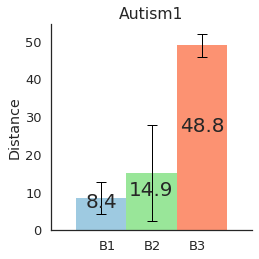

In [352]:
result = compute_prediction_distances("Prediction1(Autism).csv","Autism1")
bar_chart(list(result["Distance"].values),list(result["Task"].values),title="Autism1",yErrs=list(result["SD"].values/2.), ytitle="Distance",fixed_ylim=False)

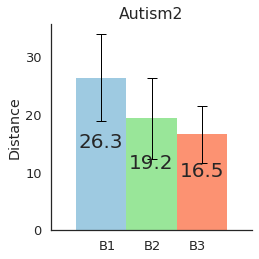

In [353]:
result = compute_prediction_distances("Prediction2(Autism).csv","Autism2")
bar_chart(list(result["Distance"].values),list(result["Task"].values),yErrs=list(result["SD"].values/2.),title="Autism2", ytitle="Distance",fixed_ylim=False)

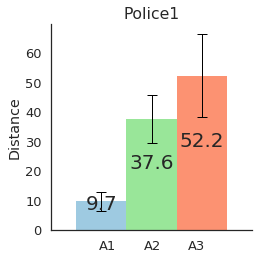

In [355]:
result = compute_prediction_distances("Prediction1(Police).csv","Police1")
bar_chart(list(result["Distance"].values),list(result["Task"].values),yErrs=list(result["SD"].values/2.),title="Police1", ytitle="Distance",fixed_ylim=False)

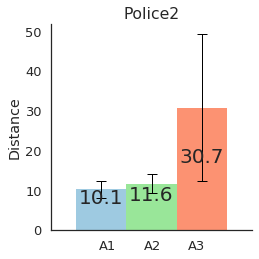

In [356]:
result = compute_prediction_distances("Prediction2(Police).csv","Police2")
bar_chart(list(result["Distance"].values),list(result["Task"].values),yErrs=list(result["SD"].values/2.),title="Police2", ytitle="Distance",fixed_ylim=False)

In [248]:
def compute_prediction_aggregate_stats(title,filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    prediction_groupby=prediction.groupby(task_name)

    result = prediction_groupby.mean().reset_index()
    std_result = prediction_groupby.apply(lambda x: x.std()).reset_index()
    return result,std_result

In [343]:
def plot_prediction_results(result,std_result,xtitle="", ytitle="", title="", top_right_text="", N=1, width=0.1,autolabel_flag =True,fixed_ylim=False):
    task_name = ""
    fig, ax = plt.subplots()
    col = 0
    x0_lst =[]
    if "Police" in title: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        print 'here'
        attributes = ["NO","YES"]
        task_name = "Task2"
    labels = result[task_name].values
    for attr in attributes:
        ind = np.arange(N)  # the x locations for the groups
        x0= (col)*(ind + (2+0.5) * width + 0.1)
        x0_lst.append(x0[0])
        yVals = result[attr].values
        xAttrs = attributes
        yErrs = std_result[attr].values/2.

        if len(yVals)==2:
            colors = ["#fc9272","#9ecae1"]
            sns.set_palette(sns.color_palette(colors))
        else:
            colors = ["#9ecae1","#99e699","#fc9272"]
            sns.set_palette(sns.color_palette(colors))

        rects = []
        error_kw=dict(lw=1, capsize=5, capthick=1)
        for i in range(len(yVals)):
            if col==0:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width,label=labels[i])
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw,label=labels[i])
            else:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width)
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw)
            rects.append(rect)

        xtitle = xtitle.replace('"', '')
        ytitle = ytitle.replace('"', '')

        ax.set_xlabel(xtitle)
        ax.set_ylabel(ytitle)
        if title != "":
            title = title.replace('"','')
            title = title.replace("#", ",\n")
            if title[0] == ',':
                title = title[2:-2]
            if title.count(',') < 3:
                ax.set_title(title)
            else:
                ax.set_title(title)
        xmin = -0.05
        xmax = 0.25 + 0.1 * (len(yVals) - 2)
        xtickpos = [np.abs(xmin - xmax) / (len(yVals) + 1.5) * (i + 0.7) for i in range(len(yVals))]
        if "Police" in title: 
            xtickpos=[0.15,0.51,0.83]
        else: 
            xtickpos=[0.14,0.48]
        ax.set_xticks(xtickpos)
        ax.set_xticklabels(xAttrs)

        if fixed_ylim: ax.set_ylim((0, 100))
        size = 0
        for rect in rects:
            size += 1
        sns.despine(top=True, right=True)
        col+=1
    for col_i in range(len(attributes)):
        if "Police" in title: 
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1*width,xtickpos[col_i]+1.5*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1.5*width,xtickpos[col_i]+1.25*width, linestyle=":",linewidth=2, color='r')
        else:
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-0.8*width,xtickpos[col_i]+3.3*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]+0.5*width,xtickpos[col_i]+4.8*width, linestyle=":",linewidth=2, color='r')

    plt.tight_layout()
    plt.ylabel("% of police stop")
    lgd = plt.legend(numpoints=1, loc="center right", bbox_to_anchor=(1.8, 0.5))
    #plt.savefig("PR_obj{0}_{1}.pdf".format(objid,postprocess), bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.show()

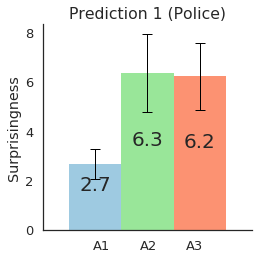

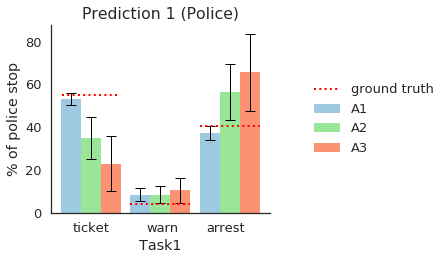

In [301]:
title="Prediction 1 (Police)"
filename = "Prediction1(Police).csv"
gt_task_key="Police1"
task_name = 'Task1'
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,task_name,title=title)

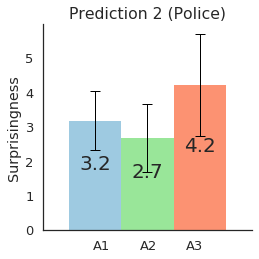

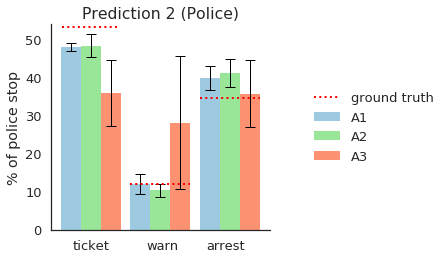

In [302]:
title="Prediction 2 (Police)"
filename = "Prediction2(Police).csv"
gt_task_key="Police2"
task_name = "Task1"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title)

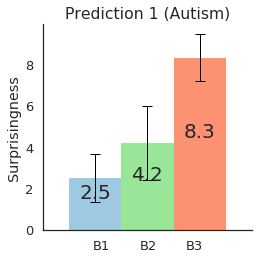

here


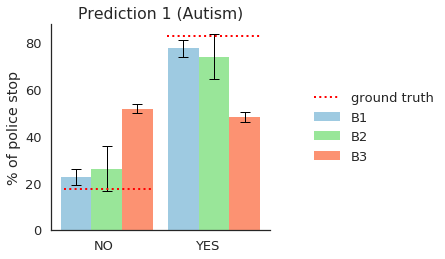

In [345]:
title="Prediction 1 (Autism)"
filename = "Prediction1(Autism).csv"
gt_task_key="Autism1"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title)

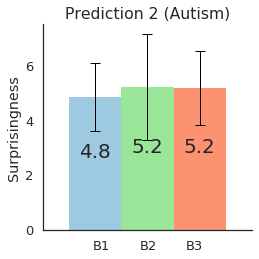

here


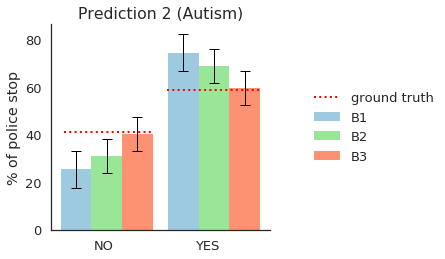

In [344]:
title="Prediction 2 (Autism)"
filename = "Prediction2(Autism).csv"
gt_task_key="Autism2"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title)